# Google Trends: Feature Exploration 1

### All Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from word_list.basic import politics1, politics2
from word_list.basic import business

## Variables

In [3]:
TRAIN_DATE_FIRST = "2004-01-04" 
TRAIN_DATE_LAST = "2012-12-16" 
INSTRUMENT = "es1"
INSTRUMENT_PRICE_COLUMN = 'PX_LAST'
INSTRUMENT_DATE_COLUMN = 'date'
CV_SPLITS = 8
K = 1

## Loading market data and defining return variable

For a day $t$, and an instrument with price $P_t$, we define the target variable $Y_t$ as the *simple return*:

\begin{equation}
Y_t = \frac{(P_t - P_{t-1})}{P_{t-1}}
\end{equation}

In [4]:
market_path = os.path.join('data','market',"{}.txt".format(INSTRUMENT))
df_market = pd.read_csv(market_path, sep='\t')
df_market.loc[:, INSTRUMENT_DATE_COLUMN] = pd.to_datetime(df_market[INSTRUMENT_DATE_COLUMN])
df_market = df_market.set_index(INSTRUMENT_DATE_COLUMN)
close = df_market[[INSTRUMENT_PRICE_COLUMN]].dropna()
target = close.pct_change().dropna()
target_name = "{}_returns".format(INSTRUMENT) 
target.columns = [target_name]
target = target[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]

display(Markdown("### {} target data ({} - {})".format(INSTRUMENT,
                                                       TRAIN_DATE_FIRST.split("-")[0],
                                                       TRAIN_DATE_LAST.split("-")[0])))
display(HTML(target.head(5).to_html()))
display(Markdown("#### shape = {}".format(target.shape))) 

### es1 target data (2004 - 2012)

,es1_returns
date,
2004-01-05,0.009919
2004-01-06,0.001782
2004-01-07,0.003123
2004-01-08,0.003556
2004-01-09,-0.008413


#### shape = (2273, 1)

## Creating features from google trends data

For a day $t$ and word $w$, ${X^{w}}_t$ is the google tred associated with $w$. We define the word feature ${D^{w}}_t$ as the $k$ difference:

\begin{equation}
{D^{w}}_t = {X^{w}}_t - {X^{w}}_{t-k}
\end{equation}

In [5]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends.append(ts)

trends = pd.concat(trends,1)
trends = trends.fillna(0.0)
trends = trends.diff(K).dropna()
word_features = list(trends.columns)
word_features.sort()
trends = trends[word_features]
trends = trends[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]


display(Markdown("### Google trends data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

### Google trends data (2004 - 2012)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-04,1.0,0.0,2.0,4.0,-10.0,0.0,-1.0,1.0,0.0,0.0,-8.0,-4.0,-5.0,11.0,-1.0,1.0,-2.0,0.0,-2.0,-8.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,-2.0,4.0,-3.0,-7.0,-2.0,1.0,3.0,1.0,3.0,1.0,3.0,5.0,0.0,-1.0,0.0,0.0,3.0,0.0,-1.0,0.0,1.0,0.0,6.0,0.0,0.0,-5.0,-2.0,3.0,-1.0,1.0,-1.0,10.0,0.0,0.0,-1.0,1.0,-4.0,1.0,-6.0,5.0,-2.0,3.0,2.0,0.0,1.0,2.0,-1.0,0.0,2.0,0.0,-5.0,7.0,-9.0,2.0,-1.0,5.0,-1.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,7.0,3.0,-2.0,1.0,1.0,1.0,-3.0,-1.0,-7.0,1.0,0.0,8.0,-1.0,3.0,-2.0,2.0,2.0,1.0,-2.0,-3.0,1.0,-3.0,-14.0,0.0,0.0,0.0,0.0,-5.0,-4.0,1.0,0.0,5.0,-1.0,6.0,3.0,0.0,0.0,2.0,0.0,-4.0,-1.0,4.0,1.0,-1.0,0.0,1.0,-12.0,-2.0,-1.0,0.0,-2.0,6.0,-1.0,1.0,1.0,-1.0,2.0,1.0,1.0,0.0,0.0,9.0,5.0,3.0,-1.0,2.0,2.0,-1.0,-2.0,1.0,2.0,4.0,3.0,-1.0,-1.0,0.0,-2.0,3.0,4.0,-6.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,-4.0,1.0,5.0,1.0,-5.0,6.0,10.0
2004-01-05,-1.0,0.0,3.0,3.0,-7.0,-3.0,0.0,-1.0,-3.0,1.0,-10.0,6.0,-2.0,-4.0,0.0,0.0,3.0,-1.0,32.0,7.0,1.0,38.0,1.0,-2.0,-1.0,2.0,0.0,-3.0,1.0,4.0,1.0,4.0,2.0,-1.0,2.0,1.0,-2.0,1.0,-2.0,0.0,27.0,0.0,1.0,2.0,1.0,1.0,2.0,-1.0,1.0,1.0,1.0,-7.0,2.0,-1.0,-4.0,0.0,1.0,-7.0,4.0,0.0,-4.0,-1.0,2.0,0.0,5.0,1.0,-1.0,-3.0,-8.0,-2.0,3.0,4.0,3.0,0.0,-2.0,-4.0,0.0,-1.0,1.0,0.0,-13.0,-7.0,0.0,-7.0,2.0,-2.0,3.0,0.0,2.0,2.0,-3.0,0.0,-4.0,-2.0,6.0,5.0,-1.0,0.0,1.0,-1.0,10.0,-3.0,4.0,0.0,15.0,-2.0,0.0,-1.0,-2.0,-1.0,0.0,3.0,0.0,0.0,3.0,-10.0,1.0,0.0,1.0,-8.0,-11.0,-1.0,1.0,1.0,-11.0,-5.0,-2.0,-3.0,3.0,1.0,-1.0,3.0,2.0,0.0,-3.0,0.0,0.0,0.0,1.0,-8.0,-2.0,1.0,-2.0,1.0,-2.0,2.0,-4.0,-2.0,-1.0,5.0,-4.0,-4.0,0.0,1.0,-9.0,6.0,-2.0,-4.0,1.0,-2.0,3.0,0.0,0.0,-3.0,-2.0,-4.0,4.0,4.0,-8.0,2.0,3.0,-6.0,-6.0,-4.0,-1.0,1.0,1.0,1.0,1.0,4.0,-1.0,3.0,5.0,-1.0,1.0,4.0,-15.0
2004-01-06,0.0,1.0,10.0,1.0,37.0,5.0,0.0,-1.0,1.0,34.0,-5.0,4.0,-4.0,10.0,0.0,1.0,-1.0,0.0,-11.0,-2.0,5.0,-1.0,13.0,1.0,1.0,-4.0,1.0,27.0,8.0,25.0,20.0,-4.0,19.0,1.0,4.0,-1.0,2.0,-2.0,1.0,14.0,4.0,0.0,0.0,-2.0,0.0,4.0,2.0,3.0,-1.0,2.0,0.0,13.0,2.0,4.0,29.0,11.0,18.0,2.0,-1.0,2.0,5.0,1.0,-1.0,-1.0,-6.0,-1.0,0.0,1.0,24.0,9.0,-10.0,11.0,1.0,0.0,5.0,2.0,0.0,40.0,0.0,7.0,0.0,6.0,1.0,14.0,26.0,7.0,-2.0,1.0,0.0,-1.0,4.0,2.0,-6.0,5.0,14.0,6.0,0.0,1.0,-2.0,6.0,23.0,10.0,8.0,2.0,-17.0,10.0,-1.0,1.0,2.0,1.0,-2.0,0.0,5.0,-2.0,-2.0,-28.0,0.0,0.0,0.0,46.0,33.0,4.0,-2.0,-1.0,6.0,13.0,5.0,5.0,-1.0,2.0,0.0,5.0,8.0,3.0,10.0,-2.0,-2.0,2.0,1.0,17.0,-7.0,0.0,6.0,0.0,5.0,-13.0,8.0,1.0,12.0,17.0,0.0,

#### shape = (3270, 187)

## Merging both datasets

We use the trend features of day $t-1$ to predict the target on day $t$. 


In [6]:
merged_df = pd.merge_asof(trends, target, left_index=True, right_index=True)
merged_df.loc[:, target_name] = merged_df[target_name].shift(-1)
merged_df = merged_df.dropna()

# 'global' and 'return' causes problems the smf.ols method
merged_df = merged_df.rename(columns={"global":"global_","return":"return_"})
word_features = [w for w in merged_df.columns if w != target_name]
merged_df = merged_df[[target_name] + word_features]

display(Markdown("### Merged data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(merged_df.head(5).to_html()))
display(Markdown("#### shape = {}".format(merged_df.shape))) 

### Merged data (2004 - 2012)

,es1_returns,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global_,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return_,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-04,0.009919,1.0,0.0,2.0,4.0,-10.0,0.0,-1.0,1.0,0.0,0.0,-8.0,-4.0,-5.0,11.0,-1.0,1.0,-2.0,0.0,-2.0,-8.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,-2.0,4.0,-3.0,-7.0,-2.0,1.0,3.0,1.0,3.0,1.0,3.0,5.0,0.0,-1.0,0.0,0.0,3.0,0.0,-1.0,0.0,1.0,0.0,6.0,0.0,0.0,-5.0,-2.0,3.0,-1.0,1.0,-1.0,10.0,0.0,0.0,-1.0,1.0,-4.0,1.0,-6.0,5.0,-2.0,3.0,2.0,0.0,1.0,2.0,-1.0,0.0,2.0,0.0,-5.0,7.0,-9.0,2.0,-1.0,5.0,-1.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,7.0,3.0,-2.0,1.0,1.0,1.0,-3.0,-1.0,-7.0,1.0,0.0,8.0,-1.0,3.0,-2.0,2.0,2.0,1.0,-2.0,-3.0,1.0,-3.0,-14.0,0.0,0.0,0.0,0.0,-5.0,-4.0,1.0,0.0,5.0,-1.0,6.0,3.0,0.0,0.0,2.0,0.0,-4.0,-1.0,4.0,1.0,-1.0,0.0,1.0,-12.0,-2.0,-1.0,0.0,-2.0,6.0,-1.0,1.0,1.0,-1.0,2.0,1.0,1.0,0.0,0.0,9.0,5.0,3.0,-1.0,2.0,2.0,-1.0,-2.0,1.0,2.0,4.0,3.0,-1.0,-1.0,0.0,-2.0,3.0,4.0,-6.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,-4.0,1.0,5.0,1.0,-5.0,6.0,10.0
2004-01-05,0.001782,-1.0,0.0,3.0,3.0,-7.0,-3.0,0.0,-1.0,-3.0,1.0,-10.0,6.0,-2.0,-4.0,0.0,0.0,3.0,-1.0,32.0,7.0,1.0,38.0,1.0,-2.0,-1.0,2.0,0.0,-3.0,1.0,4.0,1.0,4.0,2.0,-1.0,2.0,1.0,-2.0,1.0,-2.0,0.0,27.0,0.0,1.0,2.0,1.0,1.0,2.0,-1.0,1.0,1.0,1.0,-7.0,2.0,-1.0,-4.0,0.0,1.0,-7.0,4.0,0.0,-4.0,-1.0,2.0,0.0,5.0,1.0,-1.0,-3.0,-8.0,-2.0,3.0,4.0,3.0,0.0,-2.0,-4.0,0.0,-1.0,1.0,0.0,-13.0,-7.0,0.0,-7.0,2.0,-2.0,3.0,0.0,2.0,2.0,-3.0,0.0,-4.0,-2.0,6.0,5.0,-1.0,0.0,1.0,-1.0,10.0,-3.0,4.0,0.0,15.0,-2.0,0.0,-1.0,-2.0,-1.0,0.0,3.0,0.0,0.0,3.0,-10.0,1.0,0.0,1.0,-8.0,-11.0,-1.0,1.0,1.0,-11.0,-5.0,-2.0,-3.0,3.0,1.0,-1.0,3.0,2.0,0.0,-3.0,0.0,0.0,0.0,1.0,-8.0,-2.0,1.0,-2.0,1.0,-2.0,2.0,-4.0,-2.0,-1.0,5.0,-4.0,-4.0,0.0,1.0,-9.0,6.0,-2.0,-4.0,1.0,-2.0,3.0,0.0,0.0,-3.0,-2.0,-4.0,4.0,4.0,-8.0,2.0,3.0,-6.0,-6.0,-4.0,-1.0,1.0,1.0,1.0,1.0,4.0,-1.0,3.0,5.0,-1.0,1.0,4.0,-15.0
2004-01-06,0.003123,0.0,1.0,10.0,1.0,37.0,5.0,0.0,-1.0,1.0,34.0,-5.0,4.0,-4.0,10.0,0.0,1.0,-1.0,0.0,-11.0,-2.0,5.0,-1.0,13.0,1.0,1.0,-4.0,1.0,27.0,8.0,25.0,20.0,-4.0,19.0,1.0,4.0,-1.0,2.0,-2.0,1.0,14.0,4.0,0.0,0.0,-2.0,0.0,4.0,2.0,3.0,-1.0,2.0,0.0,13.0,2.0,4.0,29.0,11.0,18.0,2.0,-1.0,2.0,5.0,1.0,-1.0,-1.0,-6.0,-1.0,0.0,1.0,24.0,9.0,-10.0,11.0,1.0,0.0,5.0,2.0,0.0,40.0,0.0,7.0,0.0,6.0,1.0,14.0,26.0,7.0,-2.0,1.0,0.0,-1.0,4.0,2.0,-6.0,5.0,14.0,6.0,0.0,1.0,-2.0,6.0,23.0,10.0,8.0,2.0,-17.0,10.0,-1.0,1.0,2.0,1.0,-2.0,0.0,5.0,-2.0,-2.0,-28.0,0.0,0.0,0.0,46.0,33.0,4.0,-2.0,-1.0,6.0,13.0,5.0,5.0,-1.0,2.0,0.0,5.0,8.0,3.0,10.0,-2.0,-2.0,2.0,1.0,17.0,-7.0,0.

#### shape = (3269, 188)

## Simple Linear Regression

We use the trend feature on day $t$ to predict the target on the day $t+1$ using a simple linear regression. Thus, we assume that for each word $w$:

\begin{equation}
Y_t = \beta_0 + \beta_1 {D^{w}}_{t-1} + \epsilon_t 
\end{equation}

where $\epsilon_t \thicksim N(0, \sigma^2)$.

We calculate the cross-validation $R^2$ and RSS (Residual Sum of Squares) scores for each linear regression model. 

In [7]:
tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
r2_dict = {}
rss_dict = {}
tss_dict = {}


for feature_name in tqdm(word_features):
    r2_list = []
    rss_list = []
    tss_list = []
    date_test_index = []
    for train_index, test_index in tscv.split(merged_df):
        df_train = merged_df.iloc[train_index]
        df_test = merged_df.iloc[test_index]
        
        test_date = str(df_test.index[-1].date()) 
        date_test_index.append(test_date)

        formula = "{} ~ {}".format(target_name, feature_name)
        lr = smf.ols(formula=formula, data=df_train).fit()
        y_pred = lr.predict(df_test).values
        y_true = df_test[target_name].values
        r2 = r2_score(y_true, y_pred) 
        rss = np.sum((y_true - y_pred)**2)
        tss = np.sum((y_true - y_true.mean())**2)
        
        
        r2_list.append(r2)
        rss_list.append(rss)
        tss_list.append(tss)
        
        
    r2_dict[feature_name] = r2_list
    rss_dict[feature_name] = rss_list
    tss_dict[feature_name] = tss_list
    
    
    
result_r2 = pd.DataFrame(r2_dict)
result_r2 = result_r2.rename(columns={"global_":"global","return_":"return"})
result_rss = pd.DataFrame(rss_dict)
result_rss = result_rss.rename(columns={"global_":"global","return_":"return"})
result_tss = pd.DataFrame(tss_dict)
result_tss = result_tss.rename(columns={"global_":"global","return_":"return"})

100%|██████████| 187/187 [00:15<00:00, 12.28it/s]


## Result 1: top 5 features using cross-validation scores

In [8]:
top_all = result_r2.mean().sort_values(ascending=False).head(5)
top_all = top_all.to_frame()
top_all.columns = [r"average $R^2$"]
top_all.index.name = "words"

display(Markdown("### Average cross-validation $R^2$ score (all words)"))
display(HTML(top_all.to_html()))

top_p1 = result_r2[politics1].mean().sort_values(ascending=False).head(5)
top_p1 = top_p1.to_frame()
top_p1.columns = [r"average $R^2$"]
top_p1.index.name = "words"
top_p1_w = list(top_p1.index)

display(Markdown("### Average cross-validation $R^2$ score (Politics1)"))
display(HTML(top_p1.to_html()))

top_p2 = result_r2[politics2].mean().sort_values(ascending=False).head(5)
top_p2 = top_p2.to_frame()
top_p2.columns = [r"average $R^2$"]
top_p2.index.name = "words"
top_p2_w = list(top_p2.index)


display(Markdown("### Average cross-validation $R^2$ score (Politics2)"))
display(HTML(top_p2.to_html()))


top_b = result_r2[business].mean().sort_values(ascending=False).head(5)
top_b = top_b.to_frame()
top_b.columns = [r"average $R^2$"]
top_b.index.name = "words"
top_b_w = list(top_b.index)

display(Markdown("### Average cross-validation $R^2$ score (Business)"))
display(HTML(top_b.to_html()))

### Average cross-validation $R^2$ score (all words)

,average $R^2$
words,
color,-0.001450
seats,-0.001902
lifestyle,-0.002018
environment,-0.002031
loss,-0.002065


### Average cross-validation $R^2$ score (Politics1)

,average $R^2$
words,
democratic,-0.002317
william,-0.002419
pennsylvania,-0.002424
governor,-0.002657
served,-0.002707


### Average cross-validation $R^2$ score (Politics2)

,average $R^2$
words,
seats,-0.001902
votes,-0.002286
democratic,-0.002317
rights,-0.002373
elections,-0.002529


### Average cross-validation $R^2$ score (Business)

,average $R^2$
words,
media,-0.002353
financial,-0.002611
founded,-0.002623
energy,-0.002633
social,-0.002648


## Result 2: Category Trend

We can aggregate the words in major categories. Here we use the categories **Politics1**, **Politics2** and **Business** (first defined in  CURME et al. [Quantifying the semantics of search behavior before stock market moves](https://www.pnas.org/content/111/32/11600)).

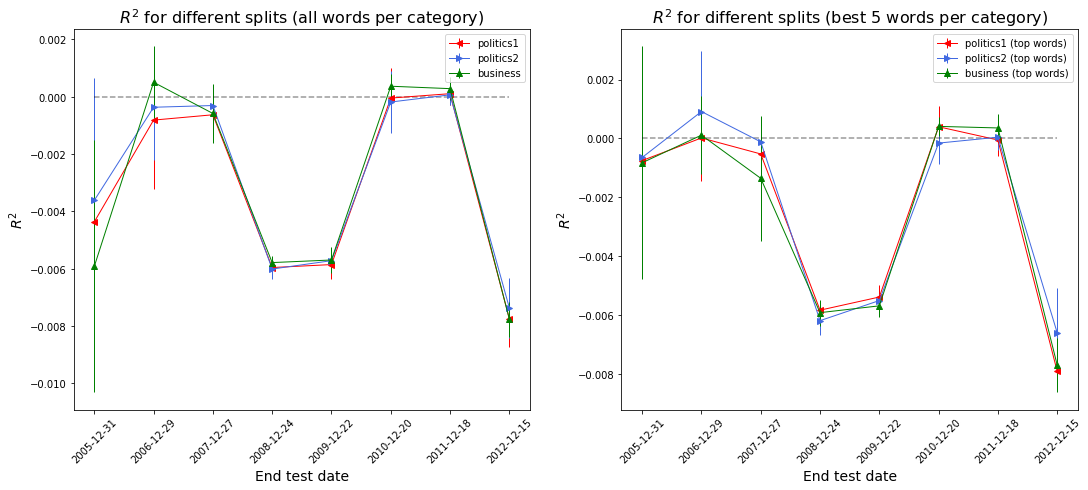

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))
ax[0].errorbar(date_test_index,
               result_r2[politics1].mean(1),
               yerr=result_r2[politics1].std(1),
               fmt='-', linewidth=1.00, label="politics1",  marker="<",  color="red");


ax[0].errorbar(date_test_index,
               result_r2[politics2].mean(1),
               yerr=result_r2[politics2].std(1),
               fmt='-', linewidth=1.00, label="politics2", marker=">", color="royalblue");


ax[0].errorbar(date_test_index,
               result_r2[business].mean(1),
               yerr=result_r2[business].std(1),
               fmt='-', linewidth=1.00, label="business",  marker="^", color="green");


ax[1].errorbar(date_test_index,
               result_r2[top_p1_w].mean(1),
               yerr=result_r2[top_p1_w].std(1),
               fmt='-', linewidth=1.00, label="politics1 (top words)",  marker="<",  color="red");


ax[1].errorbar(date_test_index,
               result_r2[top_p2_w].mean(1),
               yerr=result_r2[top_p2_w].std(1),
               fmt='-', linewidth=1.00, label="politics2 (top words)", marker=">", color="royalblue");


ax[1].errorbar(date_test_index,
               result_r2[top_b_w].mean(1),
               yerr=result_r2[top_b_w].std(1),
               fmt='-', linewidth=1.00, label="business (top words)",  marker="^", color="green");

ax[0].set_title(r"$R^2$ for different splits (all words per category)", fontsize=16);
ax[0].set_xlabel("End test date", fontsize=14);
ax[0].set_ylabel(r"$R^2$", fontsize=14);
ax[0].hlines(0,0,7, color="k", linestyle="--", alpha=0.4)
ax[0].legend(loc="best");


 

ax[1].set_title(r"$R^2$ for different splits (best 5 words per category)", fontsize=16);
ax[1].set_xlabel("End test date", fontsize=14);
ax[1].set_ylabel(r"$R^2$", fontsize=14);
ax[1].hlines(0,0,7, color="k", linestyle="--", alpha=0.4)
ax[1].legend(loc="best");


ax[0].set_xticklabels(date_test_index, rotation=45);
ax[1].set_xticklabels(date_test_index, rotation=45);

path = os.path.join("img","r2_train_cat.png")
plt.savefig(path)

In [ ]:
# sanity check
r2_test = result_r2 == 1 - (result_rss/result_tss)
assert np.all(r2_test.values)